# 实现一个简单的神经网络

1. 读取图像
2. 设置权重和偏置的初始值（正态分布）
3. 从第一张图片开始计算各个神经单元的加权输入、输出和平方误差
4. 重复3完成所有图片的计算
5. 最优化权重和偏置（反向传播）

In [1]:
import pandas as pd
import numpy as np
data=pd.read_csv('imgs.csv',header=None)
X=[data.iloc[:,3*i:3*i+3] for i in range(64)]
x = np.asarray(X)
print(x[50])
Y=pd.read_csv("labels.csv",header=None).T
y=np.array(Y.values.T)
print(y[50])

[[1 1 0]
 [1 1 0]
 [0 1 0]
 [0 1 0]]
[1]


## 用双值的形式表示正解right_y

In [2]:
right_y=np.zeros((64,2))
for i in range(64):
    if y[i]==0:
        right_y[i,0]=1
        right_y[i,1]=0
    if y[i]==1:
        right_y[i,0]=0
        right_y[i,1]=1
right_y[30:40]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

## 已完成读入图像，X是字符，y是图像识别的正解

#### 对第一张图片的举例到这里结束
#### 接下来对所有64张图片应用这个步骤计算

In [3]:
#图片
imgs=x
imgs[0:2]

array([[[1, 1, 1],
        [1, 0, 1],
        [1, 0, 1],
        [1, 1, 1]],

       [[0, 1, 1],
        [1, 0, 1],
        [1, 0, 1],
        [1, 1, 1]]], dtype=int64)

In [4]:
#网络、节点参数
class net():
    def __init__(self,_layer,_unit_list):
        self.layer_nums=_layer
        self.unit_list=_unit_list
        
class unit():
    def __init__(self,_num):
        self.unit_nums=_num

u1=unit(12)
u2=unit(3)
u3=unit(2)
mynet=net(3,[u1,u2,u3])
mynet.layer_nums

3

#### 接下来开始迭代多次优化参数

In [12]:
relu=lambda x:x if x>0 else 0
diff_relu=lambda x:1 if x>0 else 0
sigmoid=lambda x:1.0/(1+np.exp(-float(x)))
def diff_sigmoid(num):#sigmoid函数的导数
    return sigmoid(num)*(1-sigmoid(num))
MSE=lambda aIn:list(map(lambda y:sum(y)/2,
       list(map(lambda x:x**2,
                [right_y[i]-aIn[i] 
                for i in range(len(aIn))]
            ))
   ))
#权重和偏置 第一（输入）层节点没有权重和偏置
new_b=[np.random.uniform(low=0.05, high=0.05,size=mynet.unit_list[j].unit_nums)
   for j in range(1,mynet.layer_nums)]

#全连接网络 w存在于每对节点间的连接里
new_w=[np.random.uniform(low=0.05, high=0.05,size=(mynet.unit_list[j].unit_nums,mynet.unit_list[j-1].unit_nums))
   for j in range(1,mynet.layer_nums)]
mseAll=[]

print(new_b)

[array([0.05, 0.05, 0.05]), array([0.05, 0.05])]


In [6]:
#设置学习率
learning_rate=0.02
for epoch in range(400):
    #### 计算输入输出 ####
    z=[[[] for j in range(mynet.layer_nums)]for i in range(len(imgs))]
    a=[[[] for j in range(mynet.layer_nums)]for i in range(len(imgs))]
    # 第一层
    now_layer_num=0
    z[0][now_layer_num]=(imgs[now_layer_num])#第0张图片的第1层
    for imgnums in range(len(imgs)):#初始化所有图片的第一层
        z[imgnums][now_layer_num]=imgs[imgnums]
        a[imgnums][now_layer_num]=np.array(list(imgs[imgnums]))


    # 第二层
    now_layer_num+=1
    for imgnums in range(len(imgs)):#生成第二层输入
        # 前一层的输出
        tmp_front_z=a[imgnums][now_layer_num-1].flatten()
        # 第2层输入=前一层的输出*权重
        z[imgnums][now_layer_num]=np.array([sum(tmp_front_z*new_w[now_layer_num-1][i].flatten())
                                                #加上偏置
                                                +new_b[now_layer_num-1][i] 
                                           for i in range(len(new_w[now_layer_num-1]))])
        #第二层输出
        a[imgnums][now_layer_num]=np.array(list(map(sigmoid,z[imgnums][now_layer_num])))

    # 第三层
    now_layer_num+=1
    for imgnums in range(len(imgs)):
        # 前一层的输出
        tmp_front_z=a[imgnums][now_layer_num-1].flatten()
        # 第3层输入=前一层的输出*权重
        z[imgnums][now_layer_num]=np.array([sum(tmp_front_z*new_w[now_layer_num-1][i])
                                                #加上偏置
                                                +new_b[now_layer_num-1][i] 
                                           for i in range(len(new_w[now_layer_num-1]))])
        #第3层输出
        a[imgnums][now_layer_num]=np.array(list(map(sigmoid,z[imgnums][now_layer_num])))
        
    #### 接下来计算输出层的平方误差 ####
    Mean_Square_Error=np.array(MSE([a[k][2]for k in range(64)]))
    
    #### 然后根据反向传播算法，计算各层的神经单元误差 ####
    unit_error=[[np.zeros(3),np.zeros(2)]for k in range(64)] 
    #第三层的
    for k in range(64):
        unit_error[k][1]=(a[k][2]-right_y[k])*list(map(diff_sigmoid,z[k][2]))
    #第二层的
    for k in range(64):
        unit_error[k][0]=sum((unit_error[k][1]*new_w[1].T).T)*list(map(diff_sigmoid,z[k][1]))
        
    #### 接下来计算平方误差MSE对偏置b和权重w的偏导数 ####
    diff_mse_of_b=[[],[]]
    diff_mse_of_b[0]=[unit_error[k][0] for k in range(64)]
    diff_mse_of_b[1]=[unit_error[k][1] for k in range(64)]
    diff_mse_of_w=[[],[]]
    #第二层的
    diff_mse_of_w[0]=np.array([[a[k][0]*unit_error[k][0][i] 
                               for i in range(len(unit_error[0][0]))]
                                 for k in range(64)])
    #第三层的
    diff_mse_of_w[1]=np.array([[a[k][1]*unit_error[k][1][i] 
                                for i in range(len(unit_error[0][1]))]
                                   for k in range(64)])
    
    #### 代价函数与梯度 ####
    # 代价函数
    mseAll.append(sum(Mean_Square_Error))
    # 梯度
    # b
    diff_mse_of_b_layer2=diff_mse_of_b[0]
    diff_mse_of_b_layer3=diff_mse_of_b[1]
    diff_mseAll_of_b=[[],[]]
    diff_mseAll_of_b[0]=sum(diff_mse_of_b_layer2)
    diff_mseAll_of_b[1]=sum(diff_mse_of_b_layer3)
    # 梯度
    # w
    diff_mse_of_w_layer2=diff_mse_of_w[0]
    diff_mse_of_w_layer3=diff_mse_of_w[1]
    diff_mseAll_of_w=[sum(diff_mse_of_w_layer2),sum(diff_mse_of_w_layer3)]
    
    #### 最后更新参数 ####
    new_b=[new_b[i]+diff_mseAll_of_b[i]* -learning_rate for i in range(len(new_b))]
    new_w=[(new_w[0].flatten()+diff_mseAll_of_w[0].flatten()* -learning_rate).reshape(3,4,3),
       (new_w[1].flatten()+diff_mseAll_of_w[1].flatten()* -learning_rate).reshape(2,3)]
    
print(mseAll)


[16.077219127438582, 16.051705727087267, 16.033456115857685, 16.02028822247181, 16.010658069574234, 16.003476965025257, 15.997978489328872, 15.993623092344992, 15.990030305627371, 15.986930872328479, 15.984133076457933, 15.981499117896034, 15.978928558690267, 15.976346730085783, 15.973696611716125, 15.970933137178136, 15.968019193171283, 15.964922799526109, 15.961615111827603, 15.958068996387023, 15.954258002840136, 15.950155612398955, 15.94573467660865, 15.940966987163142, 15.935822935268874, 15.930271231563578, 15.924278666332736, 15.917809895864757, 15.910827245042748, 15.903290519243788, 15.89515682069238, 15.886380365864566, 15.876912301551123, 15.86670051789495, 15.855689457209785, 15.84381991773147, 15.831028851693034, 15.817249157285843, 15.802409464193696, 15.786433912487267, 15.769241924755203, 15.7507479714452, 15.730861329504727, 15.70948583456635, 15.686519627132967, 15.661854893507531, 15.635377602601395, 15.606967240276836, 15.576496543561431, 15.543831237951824, 15.5088

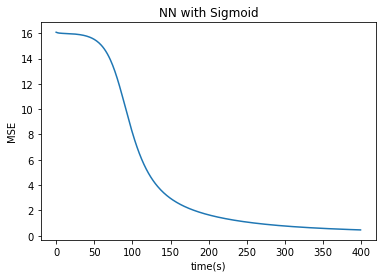

In [7]:
import matplotlib.pyplot as plt
import numpy as np

X=range(len(mseAll))  # X轴坐标数据
Y =mseAll     # Y轴坐标数据
# plt.plot(X,Y,lable="$sin(X)$",color="red",linewidth=2)

plt.figure()  # 定义图的大小
plt.xlabel("time(s)")     # X轴标签
plt.ylabel("MSE")        # Y轴坐标标签
plt.title("NN with Sigmoid")      #  曲线图的标题

plt.plot(X,Y)            # 绘制曲线图
#在ipython的交互环境中需要这句话才能显示出来
plt.show()

可以看到是在逐渐收敛的

更换一个激活函数 看看效果

In [8]:
#权重和偏置 第一（输入）层节点没有权重和偏置
new_b=[np.random.uniform(low=-0.05, high=0.05,size=mynet.unit_list[j].unit_nums)
   for j in range(1,mynet.layer_nums)]

#全连接网络 w存在于每对节点间的连接里
new_w=[np.random.uniform(low=-0.05, high=0.05,size=(mynet.unit_list[j].unit_nums,mynet.unit_list[j-1].unit_nums))
   for j in range(1,mynet.layer_nums)]


In [9]:
learning_rate=0.001

In [10]:
mseAll=[]
for epoch in range(400):
    #### 计算输入输出 ####
    z=[[[] for j in range(mynet.layer_nums)]for i in range(len(imgs))]
    a=[[[] for j in range(mynet.layer_nums)]for i in range(len(imgs))]
    # 第一层
    now_layer_num=0
    z[0][now_layer_num]=imgs[now_layer_num]#第0张图片的第1层
    for imgnums in range(len(imgs)):#初始化所有图片的第一层
        z[imgnums][now_layer_num]=imgs[imgnums]
        a[imgnums][now_layer_num]=np.array(list(imgs[imgnums]))


    # 第二层
    now_layer_num+=1
    for imgnums in range(len(imgs)):#生成第二层输入
        # 前一层的输出
        tmp_front_z=a[imgnums][now_layer_num-1].flatten()
        # 第2层输入=前一层的输出*权重
        z[imgnums][now_layer_num]=np.array([sum(tmp_front_z*new_w[now_layer_num-1][i].flatten())
                                                #加上偏置
                                                +new_b[now_layer_num-1][i] 
                                           for i in range(len(new_w[now_layer_num-1]))])
        #第二层输出
        a[imgnums][now_layer_num]=np.array(list(map(relu,z[imgnums][now_layer_num])))

    # 第三层
    now_layer_num+=1
    for imgnums in range(len(imgs)):
        # 前一层的输出
        tmp_front_z=a[imgnums][now_layer_num-1].flatten()
        # 第3层输入=前一层的输出*权重
        z[imgnums][now_layer_num]=np.array([sum(tmp_front_z*new_w[now_layer_num-1][i])
                                                #加上偏置
                                                +new_b[now_layer_num-1][i] 
                                           for i in range(len(new_w[now_layer_num-1]))])
        #第3层输出
        a[imgnums][now_layer_num]=np.array(list(map(relu,z[imgnums][now_layer_num])))
        
    #### 接下来计算输出层的平方误差 ####
    Mean_Square_Error=np.array(MSE([a[k][2]for k in range(64)]))
    
    #### 然后根据反向传播算法，计算各层的神经单元误差 ####
    unit_error=[[np.zeros(3),np.zeros(2)]for k in range(64)] 
    #第三层的
    for k in range(64):
        unit_error[k][1]=(a[k][2]-right_y[k])*list(map(diff_relu,z[k][2]))
    #第二层的
    for k in range(64):
        unit_error[k][0]=sum((unit_error[k][1]*new_w[1].T).T)*list(map(diff_relu,z[k][1]))
        
    #### 接下来计算平方误差Relu对偏置b和权重w的偏导数 ####
    diff_mse_of_b=[[],[]]
    diff_mse_of_b[0]=[unit_error[k][0] for k in range(64)]
    diff_mse_of_b[1]=[unit_error[k][1] for k in range(64)]
    diff_mse_of_w=[[],[]]
    #第二层的
    diff_mse_of_w[0]=np.array([[a[k][0]*unit_error[k][0][i] 
                               for i in range(len(unit_error[0][0]))]
                                 for k in range(64)])
    #第三层的
    diff_mse_of_w[1]=np.array([[a[k][1]*unit_error[k][1][i] 
                                for i in range(len(unit_error[0][1]))]
                                   for k in range(64)])
    
    #### 代价函数与梯度 ####
    # 代价函数
    mseAll.append(float("%.6f"%sum(Mean_Square_Error)))
    # 梯度
    # b
    diff_mse_of_b_layer2=diff_mse_of_b[0]
    diff_mse_of_b_layer3=diff_mse_of_b[1]
    diff_mseAll_of_b=[[],[]]
    diff_mseAll_of_b[0]=sum(diff_mse_of_b_layer2)
    diff_mseAll_of_b[1]=sum(diff_mse_of_b_layer3)
    # 梯度
    # w
    diff_mse_of_w_layer2=diff_mse_of_w[0]
    diff_mse_of_w_layer3=diff_mse_of_w[1]
    diff_mseAll_of_w=[sum(diff_mse_of_w_layer2),sum(diff_mse_of_w_layer3)]
    
    #### 最后更新参数 ####
    new_b=[new_b[i]+diff_mseAll_of_b[i]* -learning_rate for i in range(len(new_b))]
    new_w=[(new_w[0].flatten()+diff_mseAll_of_w[0].flatten()* -learning_rate).reshape(3,4,3),
       (new_w[1].flatten()+diff_mseAll_of_w[1].flatten()* -learning_rate).reshape(2,3)]

print(mseAll)

[31.307288, 30.394573, 29.595253, 28.895115, 28.28175, 27.744318, 27.273346, 26.860547, 26.498672, 26.181378, 25.903116, 25.659027, 25.444848, 25.25686, 25.091807, 24.946806, 24.819345, 24.707223, 24.60851, 24.521513, 24.444747, 24.376911, 24.316861, 24.263594, 24.216229, 24.173993, 24.136204, 24.102266, 24.071651, 24.043916, 24.018697, 23.995597, 23.974354, 23.954671, 23.936288, 23.918987, 23.902572, 23.886871, 23.871729, 23.857009, 23.842587, 23.82835, 23.814198, 23.800038, 23.785786, 23.771424, 23.75688, 23.742061, 23.727106, 23.71186, 23.696204, 23.680088, 23.663466, 23.646329, 23.628609, 23.610262, 23.591247, 23.571526, 23.551057, 23.529804, 23.507728, 23.484791, 23.460956, 23.436185, 23.410444, 23.383745, 23.356059, 23.327313, 23.297472, 23.266504, 23.234373, 23.201047, 23.166493, 23.13068, 23.093575, 23.05515, 23.015374, 22.974221, 22.931664, 22.887677, 22.842237, 22.795323, 22.746914, 22.696994, 22.645669, 22.592878, 22.538578, 22.482763, 22.425432, 22.366588, 22.306234, 22.244

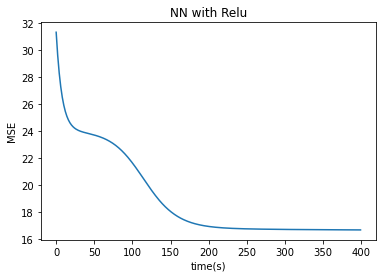

In [11]:
import matplotlib.pyplot as plt
import numpy as np

X=range(len(mseAll))  # X轴坐标数据
Y =mseAll     # Y轴坐标数据
# plt.plot(X,Y,lable="$sin(X)$",color="red",linewidth=2)

plt.figure()  # 定义图的大小
plt.xlabel("time(s)")     # X轴标签
plt.ylabel("MSE")        # Y轴坐标标签
plt.title("NN with Relu")      #  曲线图的标题

plt.plot(X,Y)            # 绘制曲线图
#在ipython的交互环境中需要这句话才能显示出来
plt.show()

可以看到，结果很好得收敛了